In [55]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt

## Current

In [78]:
class Current:
    def __init__(self, method, in_time, dt, n_step = 10):
        self.method = method
        self.inputs = dict()
        self.in_time = in_time
        self.n_step = n_step
        for t in np.arange(0, in_time+dt, dt):
            self.inputs[t] = self.method(t)
    
    def getCurrent(self, t: float) -> float:
        return self.inputs.get(t)

    def update_I(self, time: float, end_t: float, dt: float, value: float):
        i = 0
        t = time
        while i < self.n_step and t < end_t:
            self.inputs[t] += value * (time - t + 10*dt)
            t += dt
            i += 1

    def plot_I_t(self, times: np.ndarray, size_plot=(9, 5), color=u"#f0f"):
        plt.figure(figsize=size_plot)
        plt.plot(self.inputs.keys(), self.inputs.values(),
                color= color, linestyle='-', label='Current')

        plt.legend()
        plt.grid()
        plt.title('Current')
        plt.ylabel('Current (pA)')
        plt.xlabel('Time (msec)')
        plt.show()


## Neuron

In [72]:
class Neuron:
    def __init__(self, I_t: Current, is_exc = False, time_total = 100, dt = 0.25,
                R_m = 10, Tau_m = 8, V_start = -65, V_treshold = -45,
                V_spike = 5, V_rest = -65, V_reset = -65):
        self.I_t = I_t
        self.is_exc = is_exc
        self.time_total = time_total
        self.dt = dt
        self.times = np.arange(0, self.time_total, self.dt)
        self.R_m = R_m
        self.Tau_m = Tau_m
        self.V_start = V_start
        self.V_treshold = V_treshold
        self.V_spike = V_spike
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.n_fire = 0
        self.pass_time = 0
        self.spikes = []
        self.V_data = [0] * (len(self.times)+2) # save the voltage values
        self.V_data[0] = self.V_start
    
    def update(self) -> bool:
        self.has_fire = False
        index = int(self.pass_time / self.dt)
        dv = self.calculate_dv(self.I_t.getCurrent(self.pass_time), index-1)
        self.V_data[index] += self.V_data[index-1] + dv
        self.pass_time += self.dt

        if self.V_data[index] >= self.V_treshold:
            self.V_data[index-1] += self.V_spike
            self.n_fire += 1
            self.spikes.append(self.pass_time - self.dt)
            self.V_data[index] = self.V_reset
            return True
        return False

    def calculate_dv(self, I_in_t: float, index) -> float:
        dv = (- self.V_data[index] + self.V_rest) + (self.R_m * I_in_t)
        dv /= self.Tau_m
        return self.dt * dv

    def plot_voltage_time(self, size_plot = (9, 5), color = u"#503C53"):
        plt.figure(figsize=size_plot)
        plt.plot(self.times , self.V_data[0:-2], color = color, label='Voltage')
        plt.plot([0,self.time_total], [self.V_treshold, self.V_treshold],
            color=u"#f00", linestyle='--', label='Threshold Voltage')

        plt.legend()
        plt.grid()
        plt.title(f'{type(self).__name__} Model')
        plt.ylabel('Membrane Potential (mV)')
        plt.xlabel('Time (msec)')
        plt.show()

## Population

In [129]:
class Population:
    def __init__(self, time: float, neurons: list[Neuron] = [], weights: list[float] = []):
        self.neurons = neurons
        self.N = len(neurons)
        self.time = time
        self.weights = weights
        self.spikes = []

    def A(self):
        act = 0
        for n in self.neurons:
            act += n.n_fire
        
        return act / self.N
    
    def simConnection(self):
        while self.neurons[0].pass_time <= self.time:
            for i, n in enumerate(self.neurons):
                if n.update():
                    self.spikes.append([i,n.pass_time])
                    for index, other in enumerate(self.neurons):
                        if i != index and other.pass_time < other.time_total:
                            w = self.weights[index]
                            if other.is_exc:
                                w *= -1
                            other.I_t.update_I(n.pass_time + n.dt, n.time_total, n.dt, w)

    def step(self):
        has_fire = False
        for i, n in enumerate(self.neurons):
            if n.update():
                self.spikes.append([i,n.pass_time])
                for index, other in enumerate(self.neurons):
                    if i != index and other.pass_time < other.time_total:
                        w = self.weights[i]
                        if other.is_exc:
                            w *= -1
                        other.I_t.update_I(n.pass_time + n.dt, n.time_total, n.dt, w)
                        has_fire = True
        return has_fire

    def update(self, act, time):
        for i, n in enumerate(self.neurons):
            if n.pass_time < n.time_total:
                w = self.weights[i]
                if n.is_exc:
                    w *= -1
                n.I_t.update_I(time, n.time_total, n.dt, w*act)
    
    def makePopulation(self, Exc_I: Current, Inh_I: Current, n_exc = 0, n_inh = 0):
        self.neurons = []
        for i in range(n_inh):
            self.neurons.append(Neuron(Current(Inh_I, self.time, 0.25), time_total=self.time))
        for i in range(n_exc):
            self.neurons.append(Neuron(Current(Exc_I, self.time, 0.25), is_exc=True, time_total=self.time))
        w = 1 / (n_exc + n_inh)
        self.weights = [w] * (n_exc + n_inh)
        self.N = len(self.neurons)
    
    def plot(self):
        plt.figure(figsize=(15,5))
        plt.title("Raster plot")
        for i, n in enumerate(self.neurons):
            color = 'red' if n.is_exc else 'blue'
            plt.scatter(n.spikes, [i]*len(n.spikes), color=color, marker='o', s=2)
        plt.show()

## Connection 2 neuron

In [73]:
def plot_v(population: Population, title: str):
    fig, axs = plt.subplots(2, figsize=(9,5))
    fig.suptitle(title)

    n1 = population.neurons[0]
    axs[0].plot(n1.times , n1.V_data[0:-2], label='neuron 0 inh')
    axs[0].plot([0,n1.time_total], [n1.V_treshold, n1.V_treshold],
        color=u"#f00", linestyle='--', label='Threshold')
    
    n2 = population.neurons[1]
    axs[1].plot(n2.times , n2.V_data[0:-2], label='neuron 1 exc')
    axs[1].plot([0,n2.time_total], [n2.V_treshold, n2.V_treshold],
        color=u"#f00", linestyle='--', label='Threshold')

    axs[1].grid()
    axs[0].grid()
    plt.ylabel('Membrane Potential (mV)')
    plt.xlabel('Time (msec)')

    plt.show()

def plot_I(population: Population):
    fig, axs = plt.subplots(2, figsize=(9,5))
    fig.suptitle('Current')
    axs[0].plot(population.neurons[0].I_t.inputs.keys(),
            population.neurons[0].I_t.inputs.values(), label='Current', color='red')
    axs[1].plot(population.neurons[1].I_t.inputs.keys(),
            population.neurons[1].I_t.inputs.values(), label='Current', color='red')

    axs[0].grid()
    axs[1].grid()

### Inh - Exc

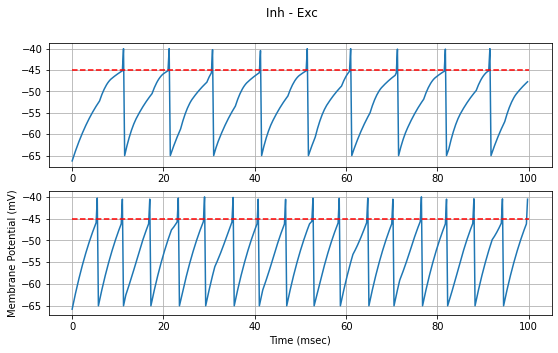

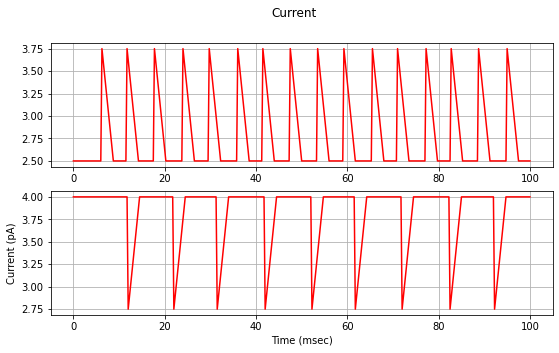

In [118]:
c1 = Current(lambda t : 2.5, 100, 0.25)
c2 = Current(lambda t : 4, 100, 0.25)
p = Population(100, [Neuron(c1), Neuron(c2, is_exc=True)], weights=[0.5, 0.5])
p.simConnection()

## plot v
plot_v(p, 'Inh - Exc')

## plot i
plot_I(p)

plt.ylabel('Current (pA)')
plt.xlabel('Time (msec)')
plt.show()

### Exc - Exc

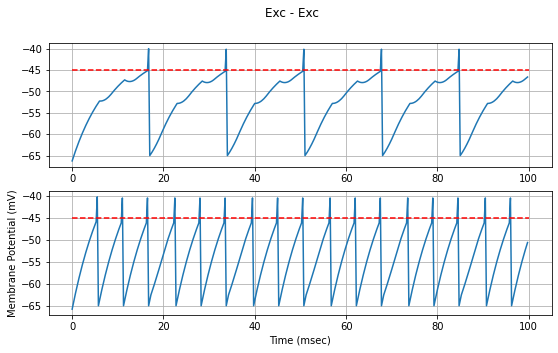

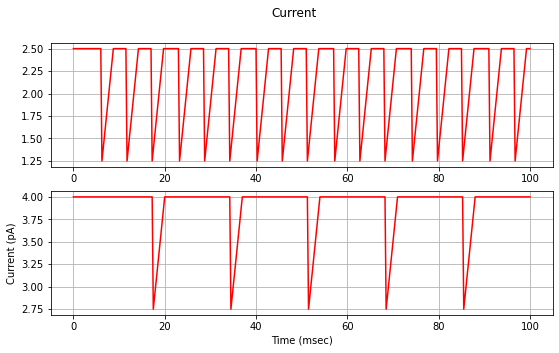

In [122]:
c1 = Current(lambda t : 2.5, 100, 0.25)
c2 = Current(lambda t : 4, 100, 0.25)
p = Population(100, [Neuron(c1, is_exc=True), Neuron(c2, is_exc=True)], weights=[0.5, 0.5])
p.simConnection()

## plot v
plot_v(p, 'Exc - Exc')

## plot i
plot_I(p)

plt.ylabel('Current (pA)')
plt.xlabel('Time (msec)')
plt.show()

### Inh - Inh

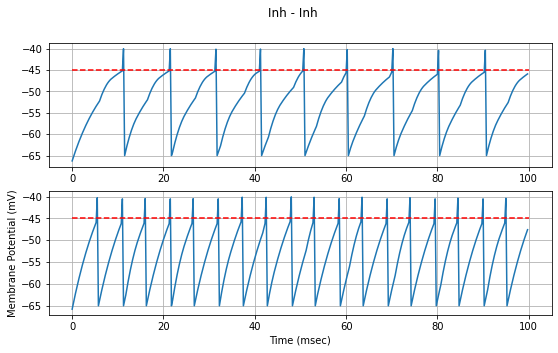

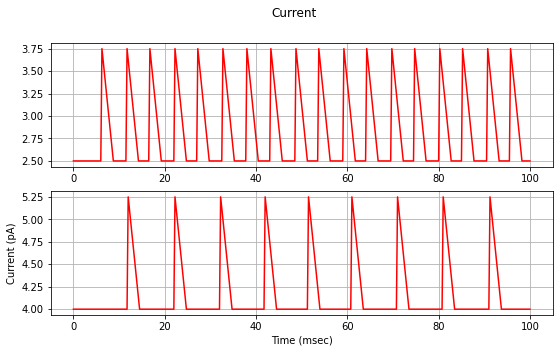

In [123]:
c1 = Current(lambda t : 2.5, 100, 0.25)
c2 = Current(lambda t : 4, 100, 0.25)
p = Population(100, [Neuron(c1), Neuron(c2)], weights=[0.5, 0.5])
p.simConnection()

## plot v
plot_v(p, 'Inh - Inh')

## plot i
plot_I(p)

plt.ylabel('Current (pA)')
plt.xlabel('Time (msec)')
plt.show()

## One population (20% exc - 80% inh)

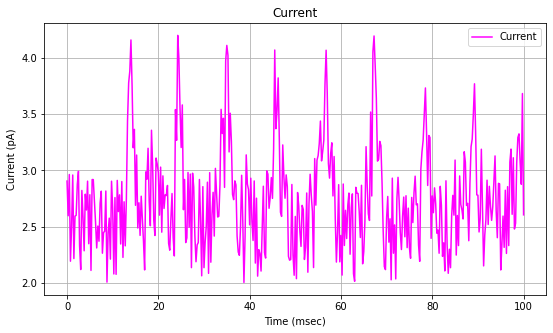

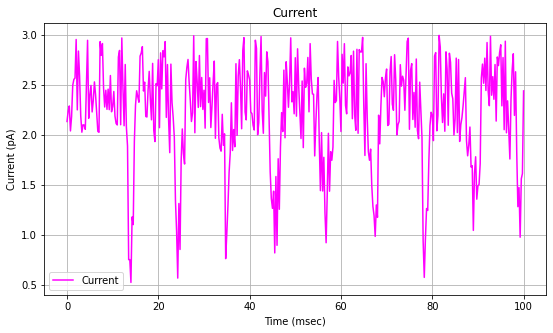

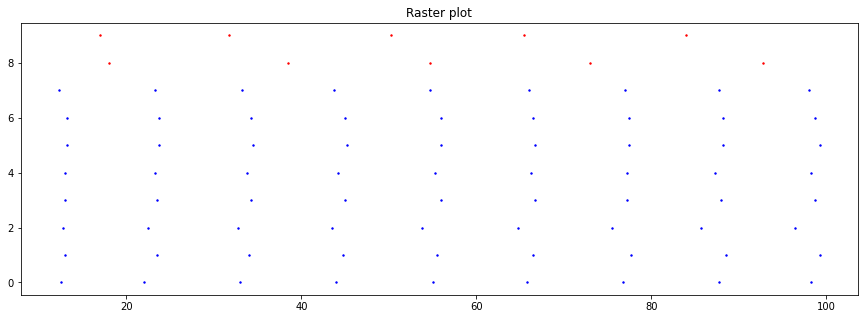

In [131]:
rand_I = lambda t : random.random()+2
p = Population(100)
p.makePopulation(rand_I, rand_I, 2, 8)
p.simConnection()
p.neurons[0].I_t.plot_I_t(100)
p.neurons[8].I_t.plot_I_t(100)
p.plot()

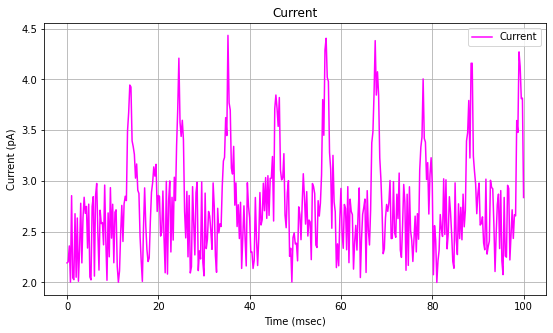

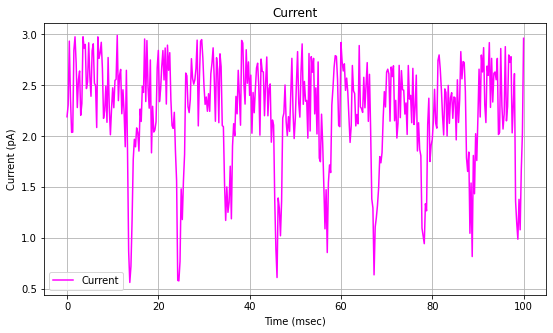

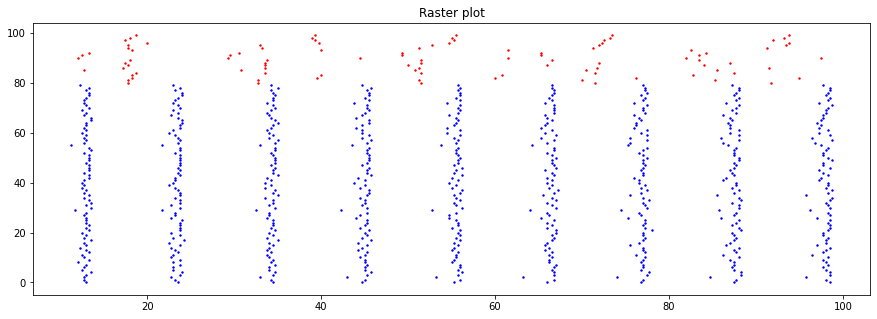

In [132]:
rand_I = lambda t : random.random()+2
p = Population(100)
p.makePopulation(rand_I, rand_I, 20, 80)
p.simConnection()
p.neurons[0].I_t.plot_I_t(100)
p.neurons[80].I_t.plot_I_t(100)
p.plot()

### 3 population

In [133]:
def network(populations: list[Population]):
    while populations[0].neurons[0].pass_time <= 100:
        for i, p in enumerate(populations):
            has = p.step()
            p_a = p.A()
            if has:
                for index, other in enumerate(populations):
                    if index != i:
                        other.update(0.3*p_a, p.neurons[0].pass_time)

    for p in populations:
        p.plot()

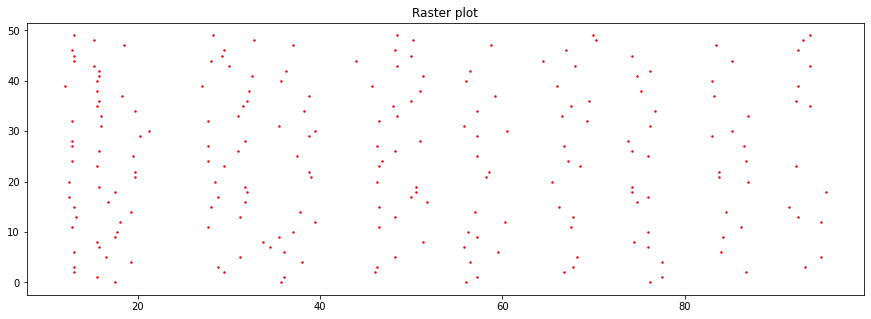

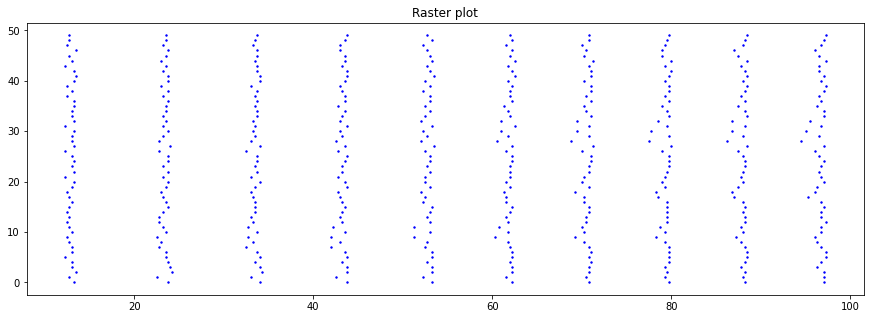

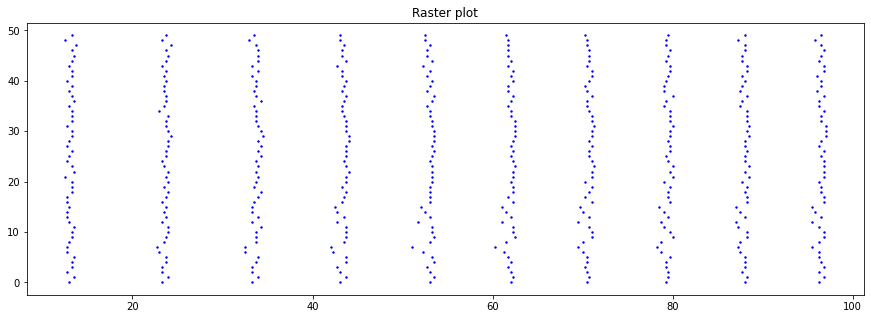

In [135]:
rand_I = lambda t : random.random()+2

p1 = Population(100)
p2 = Population(100)
p3 = Population(100)
p2.makePopulation(None, rand_I, 0, 50)
p3.makePopulation(None, rand_I, 0, 50)
p1.makePopulation(rand_I, None, 50, 0)
network([p1, p2, p3])